In [1]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('./smoke_detection_iot.csv')
df.tail()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0
62629,62629,1655130051,19.299,16.52,643,400,13696,20543,936.676,0.57,0.59,3.90,0.607,0.014,5743,0


In [3]:
df = df.drop(columns=['Unnamed: 0', 'UTC'])
df.tail()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0
62629,19.299,16.52,643,400,13696,20543,936.676,0.57,0.59,3.90,0.607,0.014,5743,0


### Normalizando os dados entre 0 e 1

In [4]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Não existem valores nulos

In [5]:
print(df.isnull().sum())
print(df.isna().sum())

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64


### Dividindo a base entre treino, teste e validação

In [6]:
X = df.drop(columns = ['Fire Alarm']) # pegando o db sem a variável resposta
y = df['Fire Alarm'] # pegando somente a variável resposta
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=2023)

# Tiro uma parte do teste para colocar na validacao
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.40, random_state=2023)

print(f" Treino {len(X_train)}, Teste {len(X_test)}, Validacao {len(X_val)}")

 Treino 37578, Teste 15031, Validacao 10021


In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',            # Métrica a ser monitorada
    patience=50,               # Número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

In [8]:
def lr_scheduler(epoch):
    if epoch < 50:
        return 0.005
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0005
    else:
        return 0.0001

# Criando o callback para o Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [9]:
def evaluate_model(model, X, y, set_name):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    confusion = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    print(f"Matriz de Confusão ({set_name}):")
    print(confusion)
    print(f"Acurácia ({set_name}): {accuracy:.4f}")
    print(f"Recall ({set_name}): {recall:.4f}")
    print(f"Precisão ({set_name}): {precision:.4f}")
    print("\n")

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 16})
    plt.title(f'Matriz de Confusão ({set_name})', size=16)
    plt.xlabel('Previsto', size=14)
    plt.ylabel('Real', size=14)
    plt.xticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.yticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.show()

### Modelo 1: MLP

In [10]:
model1 = Sequential()

model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

Epoch 1/1000
5/5 [==============================] - 1s 59ms/step - loss: 0.6550 - accuracy: 0.6099 - val_loss: 0.5709 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.5611 - accuracy: 0.7160 - val_loss: 0.5469 - val_accuracy: 0.7127 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.5332 - accuracy: 0.7203 - val_loss: 0.5077 - val_accuracy: 0.7290 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.5002 - accuracy: 0.7327 - val_loss: 0.4778 - val_accuracy: 0.7360 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.4611 - accuracy: 0.7365 - val_loss: 0.4268 - val_accuracy: 0.7371 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.4117 - accuracy: 0.7438 - val_loss: 0.3797 - val_accuracy: 0.7679 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.3

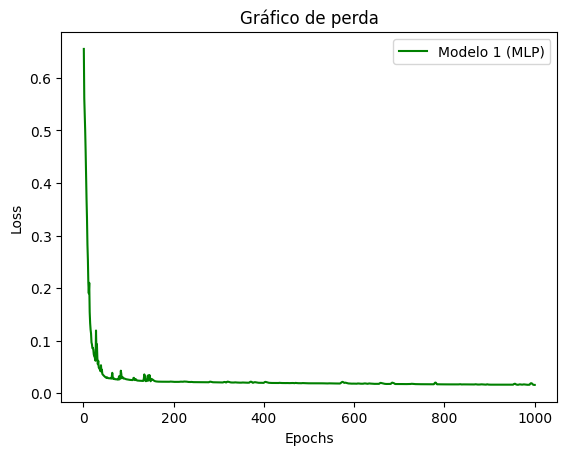

In [11]:
# Grafico do Loss
train_loss1 = history1.history['loss']
epochs = range(1, len(train_loss1) + 1)
plt.plot(epochs, train_loss1, 'g', label='Modelo 1 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Apresentação da matriz de confusão e apresentar as métricas acurácia, recall e precision envolvendo a base de treino, teste (e/ou validação).

1175/1175 [==============================] - 1s 1ms/step
Matriz de Confusão (Treino):
[[10616    57]
 [   37 26868]]
Acurácia (Treino): 0.9975
Recall (Treino): 0.9986
Precisão (Treino): 0.9979




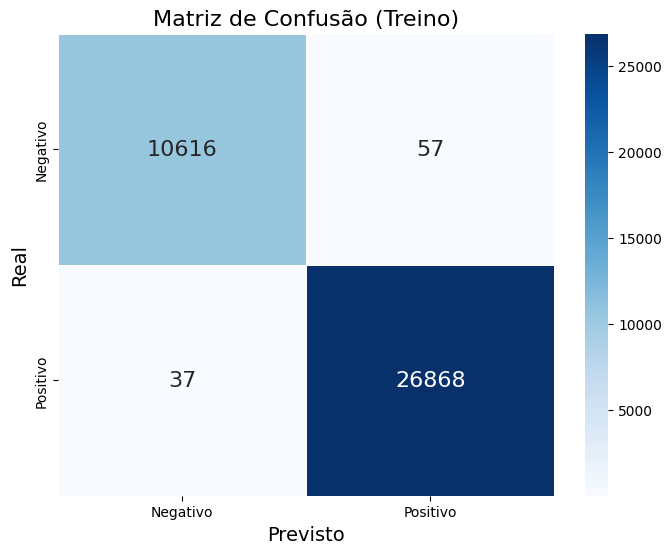

470/470 [==============================] - 0s 960us/step
Matriz de Confusão (Teste):
[[ 4295    24]
 [   12 10700]]
Acurácia (Teste): 0.9976
Recall (Teste): 0.9989
Precisão (Teste): 0.9978




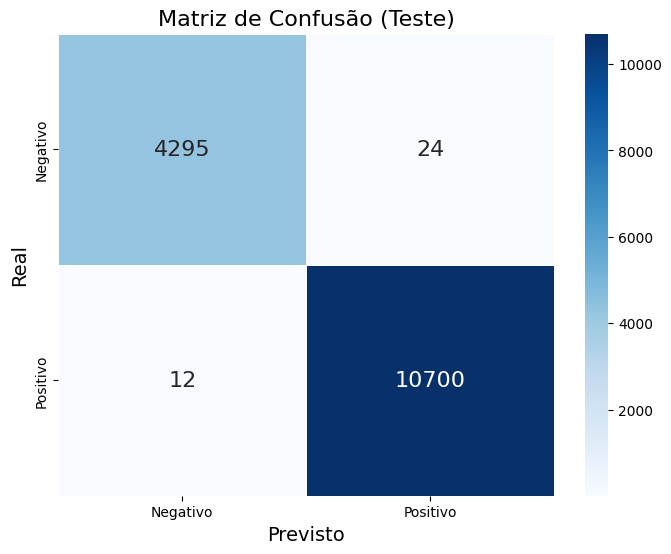

314/314 [==============================] - 0s 989us/step
Matriz de Confusão (Validação):
[[2867   14]
 [  10 7130]]
Acurácia (Validação): 0.9976
Recall (Validação): 0.9986
Precisão (Validação): 0.9980




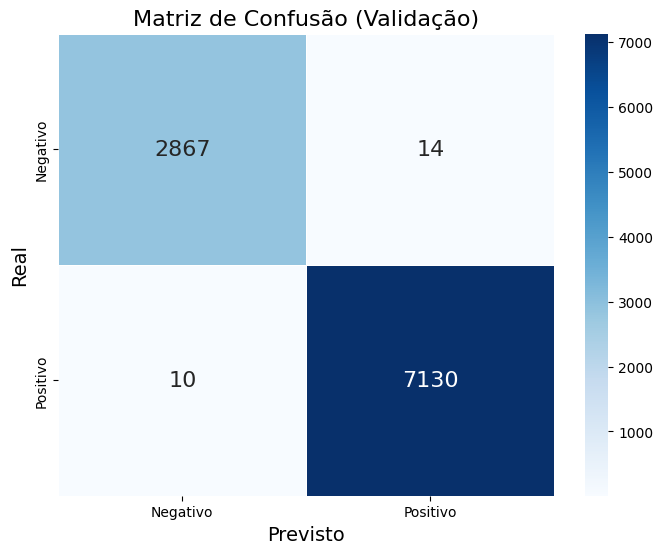

In [12]:
evaluate_model(model1, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model(model1, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model(model1, X_val, y_val, "Validação")

### Modelo 2: MLP

Epoch 1/1000
5/5 [==============================] - 2s 200ms/step - loss: 0.6834 - accuracy: 0.7160 - val_loss: 0.6828 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 1s 130ms/step - loss: 0.6811 - accuracy: 0.7160 - val_loss: 0.6786 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 1s 141ms/step - loss: 0.6769 - accuracy: 0.7160 - val_loss: 0.6728 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 1s 138ms/step - loss: 0.6712 - accuracy: 0.7160 - val_loss: 0.6674 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 1s 150ms/step - loss: 0.6657 - accuracy: 0.7160 - val_loss: 0.6624 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 1s 149ms/step - loss: 0.6609 - accuracy: 0.7160 - val_loss: 0.6582 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 1s 131ms/step - lo

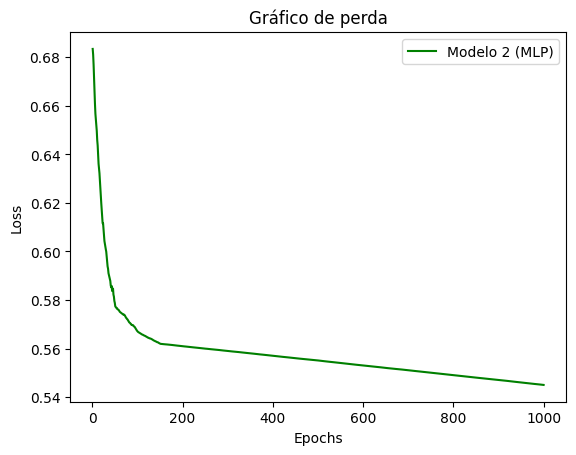

1175/1175 [==============================] - 3s 3ms/step
Matriz de Confusão (Treino):
[[    0 10673]
 [    0 26905]]
Acurácia (Treino): 0.7160
Recall (Treino): 1.0000
Precisão (Treino): 0.7160




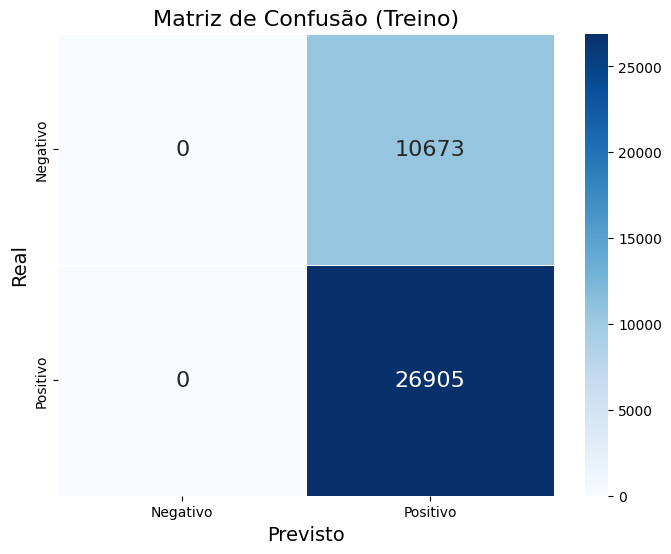

470/470 [==============================] - 1s 3ms/step
Matriz de Confusão (Teste):
[[    0  4319]
 [    0 10712]]
Acurácia (Teste): 0.7127
Recall (Teste): 1.0000
Precisão (Teste): 0.7127




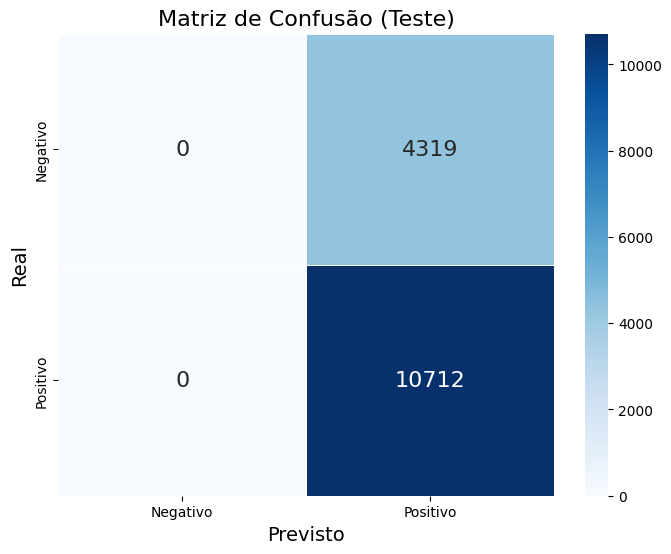

314/314 [==============================] - 1s 3ms/step
Matriz de Confusão (Validação):
[[   0 2881]
 [   0 7140]]
Acurácia (Validação): 0.7125
Recall (Validação): 1.0000
Precisão (Validação): 0.7125




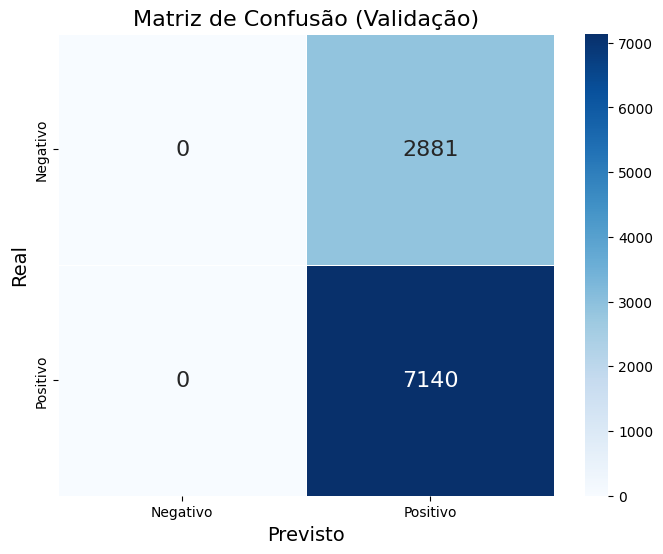

In [13]:
model2 = Sequential()

model2.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))


model2.compile(optimizer=tf.keras.optimizers.SGD(), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

# Grafico do Loss
train_loss2 = history2.history['loss']
epochs = range(1, len(train_loss2) + 1)
plt.plot(epochs, train_loss2, 'g', label='Modelo 2 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate_model(model2, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model(model2, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model(model2, X_val, y_val, "Validação")

### Modelo 3: MLP

Epoch 1/1000
5/5 [==============================] - 1s 68ms/step - loss: 0.6724 - accuracy: 0.7160 - val_loss: 0.6719 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.6713 - accuracy: 0.7160 - val_loss: 0.6706 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.6700 - accuracy: 0.7160 - val_loss: 0.6696 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.6690 - accuracy: 0.7160 - val_loss: 0.6686 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.6680 - accuracy: 0.7160 - val_loss: 0.6673 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.6668 - accuracy: 0.7160 - val_loss: 0.6667 - val_accuracy: 0.7125 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.6

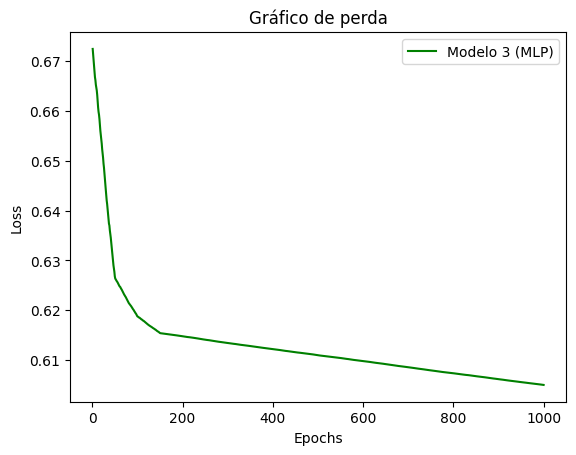

1175/1175 [==============================] - 1s 987us/step
Matriz de Confusão (Treino):
[[    0 10673]
 [    0 26905]]
Acurácia (Treino): 0.7160
Recall (Treino): 1.0000
Precisão (Treino): 0.7160




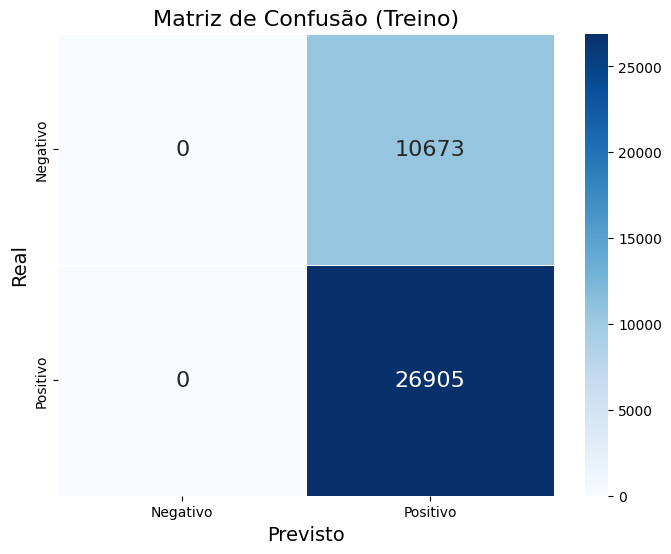

470/470 [==============================] - 0s 956us/step
Matriz de Confusão (Teste):
[[    0  4319]
 [    0 10712]]
Acurácia (Teste): 0.7127
Recall (Teste): 1.0000
Precisão (Teste): 0.7127




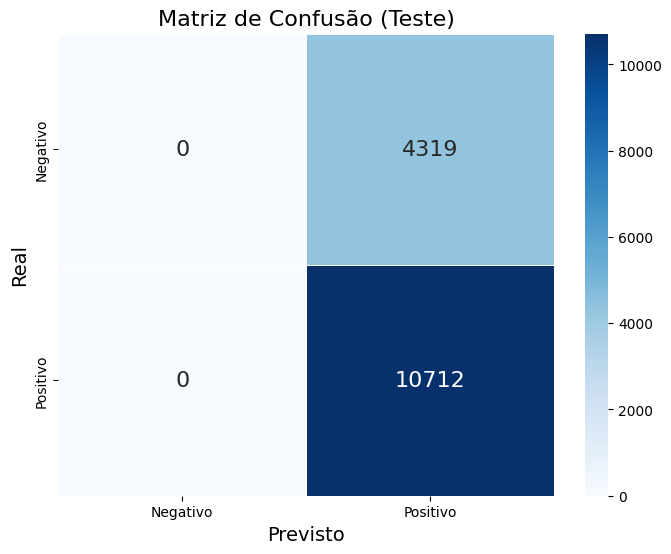

314/314 [==============================] - 0s 991us/step
Matriz de Confusão (Validação):
[[   0 2881]
 [   0 7140]]
Acurácia (Validação): 0.7125
Recall (Validação): 1.0000
Precisão (Validação): 0.7125




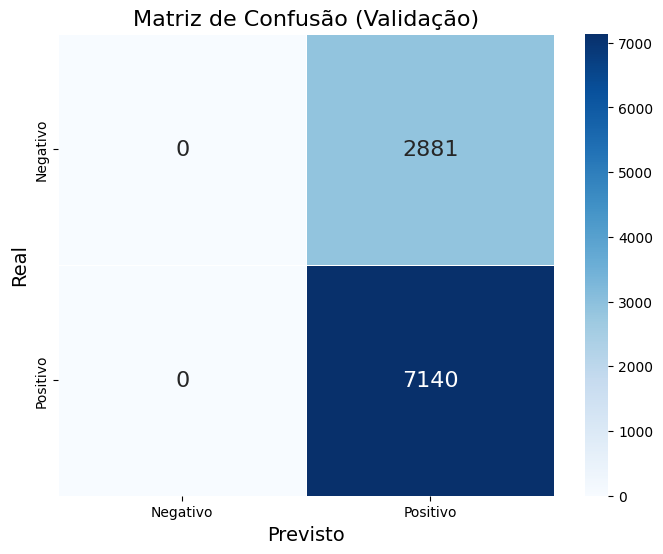

In [14]:
model3 = Sequential()

model3.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

# Grafico do Loss
train_loss3 = history3.history['loss']
epochs = range(1, len(train_loss3) + 1)
plt.plot(epochs, train_loss3, 'g', label='Modelo 3 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate_model(model3, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model(model3, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model(model3, X_val, y_val, "Validação")

### Modelo 4: Random Forest

Matriz de Confusão (Treino):
[[10673     0]
 [    0 26905]]
Acurácia (Treino): 1.0000
Recall (Treino): 1.0000
Precisão (Treino): 1.0000




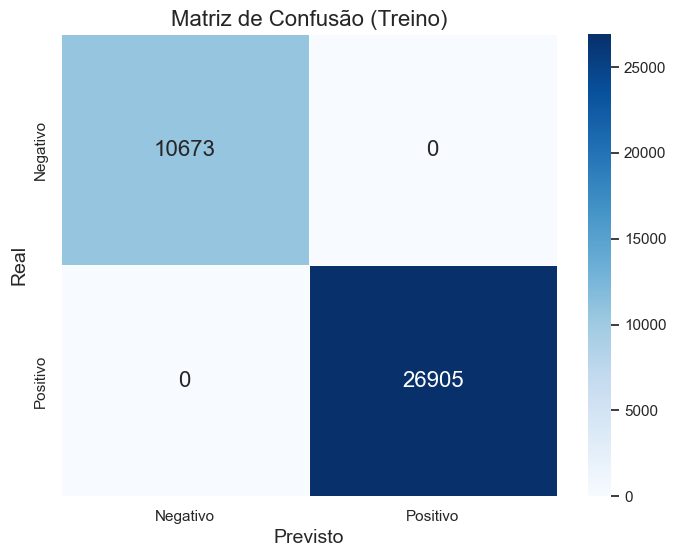

Matriz de Confusão (Teste):
[[ 4317     2]
 [    1 10711]]
Acurácia (Teste): 0.9998
Recall (Teste): 0.9999
Precisão (Teste): 0.9998




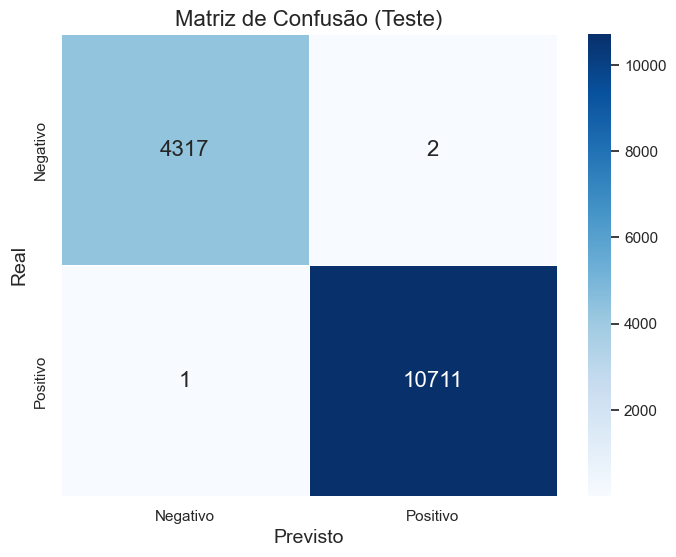

Matriz de Confusão (Validação):
[[2881    0]
 [   1 7139]]
Acurácia (Validação): 0.9999
Recall (Validação): 0.9999
Precisão (Validação): 1.0000




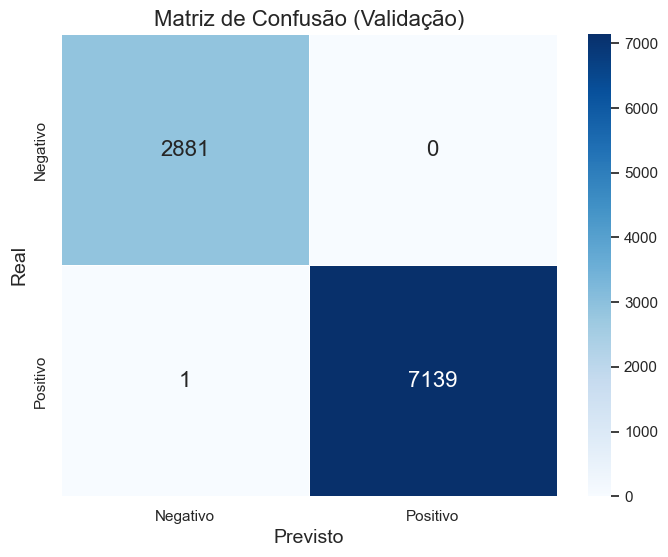

In [15]:
sns.set()

# Criar modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=2023)

# Treinar o modelo
model_rf.fit(X_train, y_train)

# Função para avaliar o modelo e gerar métricas
def evaluate_model_metrics(model, X, y, set_name):
    y_pred = model.predict(X)
    confusion = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    print(f"Matriz de Confusão ({set_name}):")
    print(confusion)
    print(f"Acurácia ({set_name}): {accuracy:.4f}")
    print(f"Recall ({set_name}): {recall:.4f}")
    print(f"Precisão ({set_name}): {precision:.4f}")
    print("\n")

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 16})
    plt.title(f'Matriz de Confusão ({set_name})', size=16)
    plt.xlabel('Previsto', size=14)
    plt.ylabel('Real', size=14)
    plt.xticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.yticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.show()

# Avaliação no conjunto de treinamento
evaluate_model_metrics(model_rf, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model_metrics(model_rf, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model_metrics(model_rf, X_val, y_val, "Validação")

### Consolidando os resultados dos grafico de loss

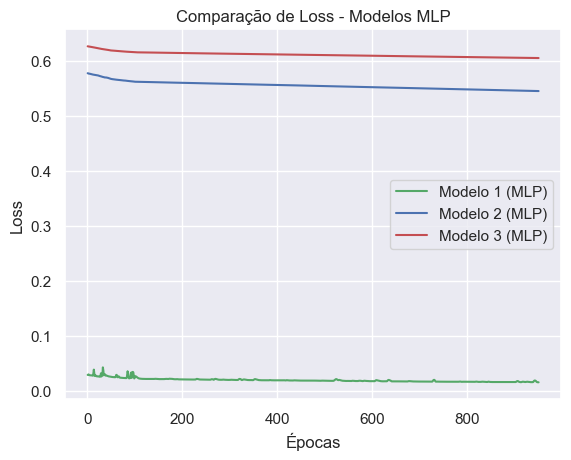

In [16]:
# Extrair informações de treinamento dos modelos
train_loss1 = history1.history['loss'][50:]
train_loss2 = history2.history['loss'][50:]
train_loss3 = history3.history['loss'][50:]

# Número de épocas
epochs = range(1, len(train_loss1) + 1)

# Plotar os gráficos de perda
plt.plot(epochs, train_loss1, 'g', label='Modelo 1 (MLP)')
plt.plot(epochs, train_loss2, 'b', label='Modelo 2 (MLP)')
plt.plot(epochs, train_loss3, 'r', label='Modelo 3 (MLP)')

# Configurações do gráfico
plt.title('Comparação de Loss - Modelos MLP')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()